In [1]:
import sys
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold, cross_val_score

from sklearn.pipeline import make_pipeline

from sklearn import metrics

import mlflow
local_tracking_uri = os.path.abspath('../' + 'mlruns')
mlflow.set_tracking_uri(local_tracking_uri)

mlflow_client = mlflow.tracking.MlflowClient()

# Custom modules

import sys
import os
ROOT_DIR = os.path.abspath('../')
sys.path.insert(0, ROOT_DIR + "/src")

import utils

# Approach

- Based on EDA results from notebook `01_eda`, the baseline we're going to use is 55% accuracy by predicting all customers being female.
- Given this dataset and a timeline of a few days, a reasonable goal is to build a classifier with 70% accuracy.

# Constants

In [2]:
TRAIN_INPUT_PATH = '../data/process/train_data_fe3.csv'
TEST_INPUT_PATH = '../data/process/test_data_fe3.csv'
LABEL_COL = 'gender'

SCORING = ['roc_auc', 'f1_micro', 'f1_weighted', 'precision', 'recall']

# Load input

In [3]:
train_df = pd.read_csv(TRAIN_INPUT_PATH)
test_df = pd.read_csv(TEST_INPUT_PATH)

In [4]:
train_df

,age = 2,age = 3,age = 4,age = 5,age = 1,age = 6,age = 0,age is unknown,SUM(txn_logs.step),SUM(txn_logs.amount),...,MODE(txn_logs.merchant) is unknown,NUM_UNIQUE(txn_logs.merchants.category),MODE(txn_logs.merchants.category) = es_transportation,MODE(txn_logs.merchants.category) = es_health,MODE(txn_logs.merchants.category) = es_wellnessandbeauty,MODE(txn_logs.merchants.category) = es_sportsandtoys,MODE(txn_logs.merchants.category) = es_fashion,MODE(txn_logs.merchants.category) = es_home,MODE(txn_logs.merchants.category) is unknown,gender
0,0,0,1,0,0,0,0,0,14681,4716.20,...,0,5,1,0,0,0,0,0,0,M
1,1,0,0,0,0,0,0,0,15401,5519.77,...,0,10,1,0,0,0,0,0,0,M
2,0,0,1,0,0,0,0,0,2494,2693.84,...,0,6,1,0,0,0,0,0,0,F
3,0,0,0,1,0,0,0,0,14099,4596.03,...,0,8,1,0,0,0,0,0,0,M
4,0,1,0,0,0,0,0,0,15827,5739.56,...,0,6,1,0,0,0,0,0,0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3275,0,1,0,0,0,0,0,0,963,2917.90,...,0,6,0,0,0,1,0,0,0,M
3276,1,0,0,0,0,0,0,0,9566,2854.58,...,0,5,1,0,0,0,0,0,0,F
3277,0,0,0,0,1,0,0,0,10407,2008.11,...,0,5,1,0,0,0,0,0,0,F
3278,0,0,1,0,0,0,0,0,960,390.57,...,0,4,0,0,0,1,0,0,0,F


In [5]:
all_df = pd.concat([train_df, test_df], axis=0)

# Generate X, y

In [6]:
le = LabelEncoder()

In [7]:
X_train, y_train = train_df.drop(columns=[LABEL_COL]), le.fit_transform(train_df[LABEL_COL])
X_test, y_test = test_df.drop(columns=[LABEL_COL]), le.transform(test_df[LABEL_COL])
X_all, y_all = all_df.drop(columns=[LABEL_COL]), le.transform(all_df[LABEL_COL])

# Hyperparm tuning

In [8]:
random_state = 42
num_folds = 3

In [9]:
kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)

In [10]:
cnt_features = X_all.shape[1]

## Hyperopt

Reference: https://www.kaggle.com/ilialar/hyperparameters-tunning-with-hyperopt

In [11]:
from hyperopt import fmin, tpe, hp, anneal, Trials

In [12]:
def rf_f1_cv(params, random_state=random_state, cv=kf, X=X_all, y=y_all):
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']),
              'min_samples_split': int(params['min_samples_split']),
              'min_samples_leaf': int(params['min_samples_leaf']),
              'max_features': int(params['max_features']),
              'bootstrap': bool(params['bootstrap'])
             }
    
    model = RandomForestClassifier(random_state=random_state, **params)
    
    score = -cross_val_score(model, X, y, cv=cv, scoring="f1_micro", n_jobs=-1).mean()

    return score

In [13]:
space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 20, 1),
       'min_samples_split': hp.quniform('min_samples_split', 3, 50, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 50, 1),
       'max_features': hp.quniform('max_features', 3, cnt_features, 1),
       'bootstrap': hp.choice('bootstrap', (True, False))
      }
# n_iter = 2
timeout = 120

trials = Trials()

best=fmin(fn=rf_f1_cv, # function to optimize
          space=space,
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
#           max_evals=n_iter, # maximum number of iterations
          timeout=timeout,
          trials=trials, # logging
          rstate=np.random.RandomState(random_state), # fixing random state for the reproducibility
         )

  0%|          | 6/9223372036854775807 [02:34<65800078811780582:58:08, 25.68s/trial, best loss: -0.5490226109904986]


In [16]:
best

{'bootstrap': 0,
 'max_depth': 3.0,
 'max_features': 29.0,
 'min_samples_leaf': 11.0,
 'min_samples_split': 34.0,
 'n_estimators': 583.0}

In [15]:
best=fmin(fn=rf_f1_cv, # function to optimize
          space=space,
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
#           max_evals=n_iter, # maximum number of iterations
          timeout=900,
          trials=trials, # logging
          rstate=np.random.RandomState(random_state), # fixing random state for the reproducibility
         )

  0%|          | 90/9223372036854775807 [15:02<25698253151841999:04:32, 10.03s/trial, best loss: -0.550976032342931] 


#### Visualize

In [19]:
tpe_results = np.array([[x['result']['loss'],
                         x['misc']['vals']['min_samples_split'][0],
                         x['misc']['vals']['min_samples_leaf'][0],
                         x['misc']['vals']['max_depth'][0],
                         x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df = pd.DataFrame(tpe_results,
                              columns=['score', 'min_samples_split',
                                     'min_samples_leaf', 'max_depth',
                                     'n_estimators'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc489977370>,
      dtype=object)

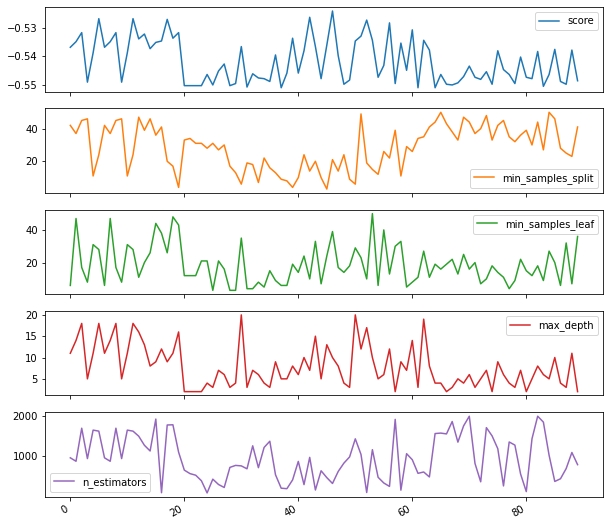

In [20]:
tpe_results_df.plot(subplots=True,figsize=(10, 10))

#### Persist trials

In [17]:
TRIAL_PERSIST_DIR = '../data/process/'

In [18]:
import pickle

filename = f"{TRIAL_PERSIST_DIR}/8-featuretools-fe3.pkl"

# The trials database now contains 100 entries, it can be saved/reloaded with pickle or another method
pickle.dump(trials, open(filename, "wb"))
trials = pickle.load(open(filename, "rb"))

# Fit

In [21]:
clf_name = "RandomForest"

In [22]:
best

{'bootstrap': 0,
 'max_depth': 3.0,
 'max_features': 29.0,
 'min_samples_leaf': 11.0,
 'min_samples_split': 34.0,
 'n_estimators': 583.0}

In [23]:
clf_params = {}
for k, v in best.items():
    if k in ('bootstrap'):
        v = bool(v)
    else:
        v = int(v)
    clf_params[k] = v

In [24]:
clf = RandomForestClassifier(**clf_params)

In [25]:
pipeline = make_pipeline(clf)

In [28]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=29, min_samples_leaf=11,
                                        min_samples_split=34,
                                        n_estimators=583))])

# Evaluate

## Cross Validation

In [26]:
train_score = cross_validate(pipeline, X_all, y_all, scoring=SCORING,
                             cv=5, return_train_score=True)

train_score_df = pd.DataFrame(train_score)
display(train_score_df)

train_score_agg_dict = train_score_df.mean(axis=0).to_dict()

train_score_agg_dict

,fit_time,score_time,test_roc_auc,train_roc_auc,test_f1_micro,train_f1_micro,test_f1_weighted,train_f1_weighted,test_precision,train_precision,test_recall,train_recall
0,4.760097,0.132731,0.511333,0.576250,0.545122,0.563110,0.394436,0.434470,0.300000,0.694444,0.008130,0.050847
1,4.971139,0.127626,0.517110,0.591524,0.547561,0.563110,0.397683,0.428496,0.400000,0.756098,0.010840,0.042034
2,4.795305,0.127677,0.449029,0.601231,0.529268,0.570122,0.407270,0.460859,0.311111,0.670157,0.037940,0.086780
3,4.681952,0.122670,0.478746,0.588341,0.540244,0.557012,0.452164,0.415205,0.453488,0.683333,0.105691,0.027797
4,5.392427,0.138186,0.475375,0.589763,0.515854,0.562500,0.410391,0.446041,0.289855,0.624242,0.054348,0.069783


{'fit_time': 4.920183944702148,
 'score_time': 0.12977795600891112,
 'test_roc_auc': 0.4863188171266211,
 'train_roc_auc': 0.5894219986251512,
 'test_f1_micro': 0.5356097560975609,
 'train_f1_micro': 0.5631707317073171,
 'test_f1_weighted': 0.41238861993289466,
 'train_f1_weighted': 0.437014026856413,
 'test_precision': 0.35089091113358045,
 'train_precision': 0.6856549662117277,
 'test_recall': 0.04338989042064333,
 'train_recall': 0.055448164990124484}

## Holdout

In [29]:
holdout_score_agg_dict = dict()
for scorer_name in SCORING:
    scorer = metrics.get_scorer(scorer_name)
    score = scorer(pipeline, X_test, y_test)
    holdout_score_agg_dict[f"holdout_{scorer_name}"] = score    

In [30]:
holdout_score_agg_dict

{'holdout_roc_auc': 0.492546213476446,
 'holdout_f1_micro': 0.525609756097561,
 'holdout_f1_weighted': 0.37600740859939435,
 'holdout_precision': 0.5384615384615384,
 'holdout_recall': 0.017948717948717947}

### Store run info in MLflow

In [31]:
experiment = mlflow.set_experiment("8-featuretools")

In [32]:
with mlflow.start_run(experiment_id=experiment):
    mlflow.log_param('data', 'fe3')
    mlflow.log_param('num_tf', None)
    mlflow.log_param('clf', clf_name)
    mlflow.log_params(clf_params)
    mlflow.log_metrics({**train_score_agg_dict, **holdout_score_agg_dict})
    mlflow.set_tag("issue", "8")

# Feature importance

In [33]:
fi_df = pd.DataFrame({'fi': clf.feature_importances_}, index=X_train.columns)
fi_df.sort_values(['fi'], ascending=False).head(20) \
    .style.bar()

,fi
SUM(txn_logs.amount),0.332176
STD(txn_logs.amount),0.209252
MAX(txn_logs.amount),0.095345
MEAN(txn_logs.amount),0.067662
MIN(txn_logs.step),0.057729
NUM_UNIQUE(txn_logs.merchant),0.055908
COUNT(txn_logs),0.049555
MIN(txn_logs.amount),0.044370
SKEW(txn_logs.amount),0.041155
SUM(txn_logs.step),0.019510


# Learning curve

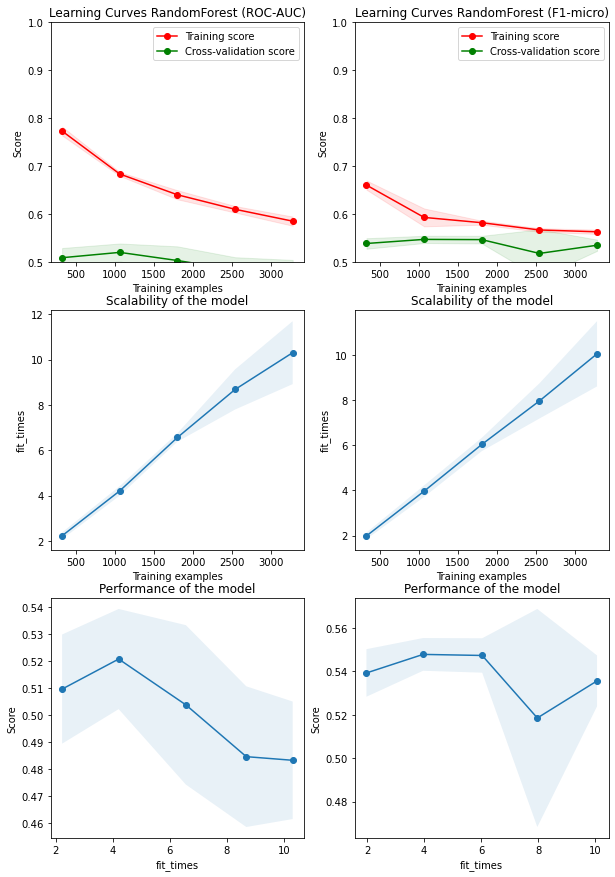

In [34]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
cv = 5
title = f"Learning Curves {clf_name} (ROC-AUC)"
train_sizes, train_scores, test_scores = \
    utils.plot_learning_curve(clf, title, X_all, y_all, axes=axes[:, 0], ylim=(0.7, 1.01),
                              cv=cv, n_jobs=8, scoring='roc_auc')

title = f"Learning Curves {clf_name} (F1-micro)"
train_sizes, train_scores, test_scores = \
    utils.plot_learning_curve(clf, title, X_all, y_all, axes=axes[:, 1], ylim=(0.7, 1.01),
                              cv=cv, n_jobs=8, scoring='f1_micro')

plt.show()

# SelectFromModel

In [110]:
clf = pipeline.named_steps['randomforestclassifier']

fs = SelectFromModel(clf, prefit=True)

X_fs = fs.transform(X_all)

X_fs.shape

(4100, 30)

In [111]:
fs_score = cross_validate(pipeline, X_fs, y_all, scoring=SCORING,
                          cv=5, return_train_score=True)

fs_score_df = pd.DataFrame(fs_score)
display(fs_score_df)

fs_score_agg_dict = fs_score_df.mean(axis=0).to_dict()

fs_score_agg_dict

,fit_time,score_time,test_roc_auc,train_roc_auc,test_f1_micro,train_f1_micro,test_f1_weighted,train_f1_weighted,test_precision,train_precision,test_recall,train_recall
0,3.595159,0.218142,0.503422,0.645671,0.552439,0.574085,0.438912,0.462486,0.520833,0.724138,0.067751,0.085424
1,3.663644,0.240230,0.542781,0.659033,0.551220,0.567073,0.424570,0.437124,0.515152,0.783505,0.046070,0.051525
2,3.824491,0.230345,0.499570,0.643025,0.542683,0.578963,0.437873,0.479226,0.451613,0.704348,0.075881,0.109831
3,4.117708,0.228578,0.504011,0.641555,0.551220,0.550915,0.393062,0.392050,1.000000,1.000000,0.002710,0.001356
4,3.887132,0.223648,0.520032,0.658224,0.552439,0.556098,0.394488,0.404939,1.000000,0.916667,0.002717,0.014905


{'fit_time': 3.8176269054412844,
 'score_time': 0.22818856239318847,
 'test_roc_auc': 0.5139631443941703,
 'train_roc_auc': 0.6495014747557484,
 'test_f1_micro': 0.55,
 'train_f1_micro': 0.5654268292682927,
 'test_f1_weighted': 0.4177810795734784,
 'train_f1_weighted': 0.4351651277640082,
 'test_precision': 0.697519550342131,
 'train_precision': 0.8257315156854563,
 'test_recall': 0.039025863084717796,
 'train_recall': 0.0526081484543659}

In [112]:
with mlflow.start_run(experiment_id=experiment):
    mlflow.log_param('data', 'fe21')
    mlflow.log_param('num_tf', None)
    mlflow.log_param('clf', clf_name)
    mlflow.log_param('cnt_features', X_fs.shape[1])
    mlflow.log_params(clf_params)
    mlflow.log_metrics(fs_score_agg_dict)
    mlflow.set_tag("issue", "11")

Reducing from 86 features to 30 features does not affect model's performance. In production, this will be a huge advantages because of less complexity, less time required to produce and maintain the features.

# Archive

In [52]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

# MLflow

In [167]:
mlflow.search_runs()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.holdout_precision,metrics.train_precision,metrics.holdout_f1_weighted,metrics.score_time,...,params.clf,params.data,params.max_iter,params.num_tf,params.cv,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.note.content,tags.eval_set
0,cfe84ff3ee5341cc889f79ba61d8acda,0,FINISHED,/home/quydv1/frostmourne/lich/banksim/mlruns/0...,2020-07-14 17:34:04.895000+00:00,2020-07-14 17:34:05.056000+00:00,0.479592,0.556411,0.500156,0.021375,...,LogisticRegression,fe2,2000,PowerTransformer,None,/home/quydv1/anaconda3/envs/banksim/lib/python...,LOCAL,quydv1,None,None
1,a1448fafcd924ea385ed2b33e2717a04,0,FINISHED,/home/quydv1/frostmourne/lich/banksim/mlruns/0...,2020-07-14 17:28:26.927000+00:00,2020-07-14 17:28:27.089000+00:00,0.460432,0.544958,0.471899,0.009517,...,LogisticRegression,fe2,2000,StandardScaler,None,/home/quydv1/anaconda3/envs/banksim/lib/python...,LOCAL,quydv1,None,None
2,41b94130e16048d88fa703a44f39ff8f,0,FINISHED,/home/quydv1/frostmourne/lich/banksim/mlruns/0...,2020-07-14 16:26:50.776000+00:00,2020-07-14 16:26:50.840000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,/home/quydv1/anaconda3/envs/banksim/lib/python...,LOCAL,quydv1,None,None
3,2b054f5f9ec7457fbbdcc66fb1212b7e,0,FINISHED,/home/quydv1/frostmourne/lich/banksim/mlruns/0...,2020-07-14 16:06:36.456000+00:00,2020-07-14 16:06:36.604000+00:00,NaN,0.200000,NaN,0.012698,...,LogisticRegressionCV,fe1,1000,PowerTransformer,5,/home/quydv1/anaconda3/envs/banksim/lib/python...,LOCAL,quydv1,Ignore results due to a bug at https://github....,train


In [168]:
run_obj = mlflow_client.get_run('cfe84ff3ee5341cc889f79ba61d8acda')

In [169]:
mlflow_client.set_tag(run_obj.info.run_id, "issue", "9")

In [ ]:
run_obj.data